# Proyecto Final - Analisis De Datos

## Recopilación y Transformación de Datos (ETL)

Buscamos construir un modelo de predicción de churn (abandono de clientes), utilizando tanto información:

- Financiera y demográfica (edad, balance, salario, país, etc.),
- Macroeconómica (ingresos medios, desempleo, educación),
- De comportamiento digital (uso de la app, frecuencia de sesiones, tipo de dispositivo, etc.).

El objetivo principal es predecir si un cliente continuará o no con el producto/servicio de la empresa (variable Exited).

Este análisis permite:

- Identificar clientes en riesgo de abandonar
- Diseñar estrategias de retención personalizadas
- Optimizar campañas de fidelización
- Aumentar la rentabilidad reduciendo el churn rate.

### Importacion De Librerias

In [14]:
%pip install pandas openpyxl numpy matplotlib seaborn sqlite3

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sqlite3 (from versions: none)

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\juan.gaviria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for sqlite3


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import openpyxl

### Leer Datos

1. Leemos los datos de `Churn_Modelling.csv` (csv)
    - Esta tabla contiene la información socioeconómica, financiera y de relación con la empresa de cada cliente.

In [16]:
df = pd.read_csv('./Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


2. Leemos los datos de los paises desde `country-data.xlsx` (Excel)
    - Esta base permite enriquecer la información del cliente con variables macroeconómicas y demográficas según su país, ofreciendo contexto sobre el entorno en el que vive.

In [17]:

countries = pd.read_excel('./country-data.xlsx')
countries.head()

,Country,AvgIncome_USD,UnemploymentRate_%,PopulationDensity_pkm2,EducationIndex,GDP_perCapita_USD
0,France,43000,7.5,119,0.88,46000
1,Spain,35000,12.2,94,0.84,38000
2,Germany,48000,5.6,233,0.91,52000
3,Italy,36000,9.8,200,0.85,41000
4,United Kingdom,45000,4.3,280,0.89,50000


3. Leemos los datos de comportamiento digital desde `digital_behavior.db` (Sqlite)
    - Esta base aporta información sobre el comportamiento digital del cliente, ayudando a entender su nivel de interacción con la plataforma.

In [18]:

conn = sql.connect('digital_behavior.db')

digital_behavior = pd.read_sql("SELECT * FROM DigitalBehavior;", conn)
digital_behavior.head()

,Identification,AvgSessionPerWeek,AvgSessionDuration_min,DaysSinceLastLogin,DeviceType,NumTransactionsApp,TimeOfDayMostActive,PushNotificationsEnabled,BiometricLoginUsed,DarkModeEnabled
0,15687492,1,9.1,81,Android,11,Night,0,1,0
1,15736963,4,6.5,78,iOS,8,Morning,1,0,1
2,15721730,3,12.7,57,Android,11,Afternoon,1,0,1
3,15762134,9,6.4,88,Web,13,Morning,0,1,1
4,15648898,4,9.6,47,iOS,11,Evening,0,0,1


## ETL

1. Relacionamos las diferentes fuentes de datos

In [19]:
# Relacion con paises
df = df.merge(countries, left_on='Geography', right_on='Country', how='left')

df.drop(columns=['Geography'], inplace=True) # Eliminar columna duplicada

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Country,AvgIncome_USD,UnemploymentRate_%,PopulationDensity_pkm2,EducationIndex,GDP_perCapita_USD
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,1,1,101348.88,1,France,43000,7.5,119,0.88,46000
1,2,15647311,Hill,608,Female,41,1,83807.86,1,0,1,112542.58,0,Spain,35000,12.2,94,0.84,38000
2,3,15619304,Onio,502,Female,42,8,159660.80,3,1,0,113931.57,1,France,43000,7.5,119,0.88,46000
3,4,15701354,Boni,699,Female,39,1,0.00,2,0,0,93826.63,0,France,43000,7.5,119,0.88,46000
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,1,1,79084.10,0,Spain,35000,12.2,94,0.84,38000


In [20]:
## Relacion con comportamiento digital
df = df.merge(digital_behavior, left_on="CustomerId", right_on="Identification", how="left")

df.drop(columns=['Identification'], inplace=True) # Eliminar columna duplicada

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,GDP_perCapita_USD,AvgSessionPerWeek,AvgSessionDuration_min,DaysSinceLastLogin,DeviceType,NumTransactionsApp,TimeOfDayMostActive,PushNotificationsEnabled,BiometricLoginUsed,DarkModeEnabled
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,1,...,46000,4,1.5,72,iOS,9,Morning,1,1,1
1,2,15647311,Hill,608,Female,41,1,83807.86,1,0,...,38000,4,8.3,53,Web,17,Morning,1,1,1
2,3,15619304,Onio,502,Female,42,8,159660.80,3,1,...,46000,7,6.5,66,Android,10,Morning,1,1,0
3,4,15701354,Boni,699,Female,39,1,0.00,2,0,...,46000,10,8.0,74,Web,12,Morning,1,0,1
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,1,...,38000,6,8.1,45,Web,9,Night,1,0,0


2. Renombrar columnas para estandarizar

In [21]:
df = df.rename(columns={
    "RowNumber": "row_number",
    "CustomerId": "customer_id",
    "Surname": "surname",
    "CreditScore": "credit_score",
    "Gender": "gender",
    "Age": "age",
    "Tenure": "tenure_years",
    "Balance": "account_balance",
    "NumOfProducts": "num_products",
    "HasCrCard": "has_credit_card",
    "IsActiveMember": "is_active_member",
    "EstimatedSalary": "estimated_salary",
    "Geography": "country", # estaba como "Country": "country", esa columna se elimina en un paso anterior
    "AvgIncome_USD": "avg_income_usd",
    "UnemploymentRate_%": "unemployment_rate_percent",
    "PopulationDensity_pkm2": "population_density_per_km2",
    "EducationIndex": "education_index",
    "GDP_perCapita_USD": "gdp_per_capita_usd",
    "AvgSessionPerWeek": "avg_sessions_per_week",
    "AvgSessionDuration_min": "avg_session_duration_min",
    "DaysSinceLastLogin": "days_since_last_login",
    "DeviceType": "device_type",
    "NumTransactionsApp": "num_transactions_app",
    "TimeOfDayMostActive": "most_active_time_of_day",
    "PushNotificationsEnabled": "push_notifications_enabled",
    "BiometricLoginUsed": "biometric_login_used",
    "DarkModeEnabled": "dark_mode_enabled",
    "Exited": "exited"
})

df.head()

,row_number,customer_id,surname,credit_score,gender,age,tenure_years,account_balance,num_products,has_credit_card,...,gdp_per_capita_usd,avg_sessions_per_week,avg_session_duration_min,days_since_last_login,device_type,num_transactions_app,most_active_time_of_day,push_notifications_enabled,biometric_login_used,dark_mode_enabled
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,1,...,46000,4,1.5,72,iOS,9,Morning,1,1,1
1,2,15647311,Hill,608,Female,41,1,83807.86,1,0,...,38000,4,8.3,53,Web,17,Morning,1,1,1
2,3,15619304,Onio,502,Female,42,8,159660.80,3,1,...,46000,7,6.5,66,Android,10,Morning,1,1,0
3,4,15701354,Boni,699,Female,39,1,0.00,2,0,...,46000,10,8.0,74,Web,12,Morning,1,0,1
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,1,...,38000,6,8.1,45,Web,9,Night,1,0,0


3. Informacion de las columnas antes de transformarlas

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   row_number                  10000 non-null  int64  
 1   customer_id                 10000 non-null  int64  
 2   surname                     10000 non-null  object 
 3   credit_score                10000 non-null  int64  
 4   gender                      10000 non-null  object 
 5   age                         10000 non-null  int64  
 6   tenure_years                10000 non-null  int64  
 7   account_balance             10000 non-null  float64
 8   num_products                10000 non-null  int64  
 9   has_credit_card             10000 non-null  int64  
 10  is_active_member            10000 non-null  int64  
 11  estimated_salary            10000 non-null  float64
 12  exited                      10000 non-null  int64  
 13  Country                     1000

- Todos los valores estan completos, no hay nulos
- Hay valores de 0/1 como enteros

In [23]:
# Fila de ejemplo
print(df.iloc[0])


row_number                            1
customer_id                    15634602
surname                        Hargrave
credit_score                        619
gender                           Female
age                                  42
tenure_years                          2
account_balance                     0.0
num_products                          1
has_credit_card                       1
is_active_member                      1
estimated_salary              101348.88
exited                                1
Country                          France
avg_income_usd                    43000
unemployment_rate_percent           7.5
population_density_per_km2          119
education_index                    0.88
gdp_per_capita_usd                46000
avg_sessions_per_week                 4
avg_session_duration_min            1.5
days_since_last_login                72
device_type                         iOS
num_transactions_app                  9
most_active_time_of_day         Morning


4. Transformacion

In [24]:
# Convertir columnas binarias (0/1) a Booleano
binary_cols = [
    "has_credit_card",
    "is_active_member",
    "push_notifications_enabled",
    "biometric_login_used",
    "dark_mode_enabled",
    "exited"
]
df[binary_cols] = df[binary_cols].astype(bool)

# Normalizar texto en columnas categóricas
df["gender"] = df["gender"].str.strip().str.capitalize()
df["Country"] = df["Country"].str.strip().str.title()
df["device_type"] = df["device_type"].str.strip().str.lower()
df["most_active_time_of_day"] = df["most_active_time_of_day"].str.strip().str.capitalize()

# Convertir columnas numéricas a tipo adecuado dtype
numeric_cols = [
    "credit_score", "age", "tenure_years", "account_balance", "num_products",
    "estimated_salary", "avg_income_usd", "unemployment_rate_percent",
    "population_density_per_km2", "education_index", "gdp_per_capita_usd",
    "avg_sessions_per_week", "avg_session_duration_min", "days_since_last_login",
    "num_transactions_app"
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Crear columna que indique si el cliente tiene balance positivo
df["has_balance"] = df["account_balance"] > 0

# Crear columna por grupo de edad
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 25, 40, 60, 100],
    labels=["Youth", "Adult", "Middle-age", "Senior"]
)

# Crear columna por grupo de ingresos
df["income_group"] = pd.cut(
    df["avg_income_usd"],
    bins=[0, 30000, 60000, 100000, np.inf],
    labels=["Low", "Lower-Middle", "Upper-Middle", "High"]
)

# Convertir columnas de texto categóricas a tipo category
categorical_cols = [
    "gender",
    "Country",
    "device_type",
    "most_active_time_of_day",
    "age_group"
]
df[categorical_cols] = df[categorical_cols].astype("category")

# Mover 'exited' al final
df['exited'] = df.pop('exited')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   row_number                  10000 non-null  int64   
 1   customer_id                 10000 non-null  int64   
 2   surname                     10000 non-null  object  
 3   credit_score                10000 non-null  int64   
 4   gender                      10000 non-null  category
 5   age                         10000 non-null  int64   
 6   tenure_years                10000 non-null  int64   
 7   account_balance             10000 non-null  float64 
 8   num_products                10000 non-null  int64   
 9   has_credit_card             10000 non-null  bool    
 10  is_active_member            10000 non-null  bool    
 11  estimated_salary            10000 non-null  float64 
 12  Country                     10000 non-null  category
 13  avg_income_usd   

In [25]:
df.to_csv('Churn_Modelling-ETL 2.csv', index=False)

# Análisis Exploratorio de Datos (EDA)

Con el Objetivo de obtener una comprensión profunda de la estructura, calidad, patrones y relaciones presentes en  en nuestra nueva estructura de datos se realiza el EDA, etapa fundamental en cualquier proyecto de análisis o machine learning.

In [26]:
# Copia de df, evitando tener que ejecutar los codigos anteriores
# ejecutar solo una vez
df_copy = df.copy()


In [27]:
# Ejecutar segun necesidad
df = df_copy

In [28]:
#Solo si no se tiene la libreria
%pip install plotly.express

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------  9.7/9.9 MB 50.5 MB/s eta 0:00:01
   ---------------------------------------- 9.9/9.9 MB 41.2 MB/s  0:00:00
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------  9.4/9.6 MB 73.4 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 46.2 MB/s  0:00:00

   ---------------------------------------- 0/5 [patsy]
   ---------------------------------------- 0/5 [patsy]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ------------------------------- 1/5 [narwhals]
   -------- ----------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\juan.gaviria\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Inspeccion inicial

In [29]:
# Librerias para este paso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Configuracion de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

In [30]:
def load_and_inspect(df):
    print("="*50)
    print("INSPECCION INICIAL")
    print("="*50)
    
    # Informacion basica
    print(f"Dataset Shape: {df.shape}")
    print(f"\nNombre de Columnas:\n{df.columns.tolist()}")
    
    # Data types and missing values
    print("\nTipo de Data, data nula:")
    info_df = pd.DataFrame({
        'Data Type': df.dtypes,
        'Missing Values': df.isnull().sum(),
        'Missing %': (df.isnull().sum() / len(df)) * 100,
        'Unique Values': df.nunique()
    })
    display(info_df)
    
    # Display first few rows
    print("\nPrimeras filas:")
    display(df.head())
    
    return info_df

# Execute the function
info_df = load_and_inspect(df)

INSPECCION INICIAL
Dataset Shape: (10000, 31)

Nombre de Columnas:
['row_number', 'customer_id', 'surname', 'credit_score', 'gender', 'age', 'tenure_years', 'account_balance', 'num_products', 'has_credit_card', 'is_active_member', 'estimated_salary', 'Country', 'avg_income_usd', 'unemployment_rate_percent', 'population_density_per_km2', 'education_index', 'gdp_per_capita_usd', 'avg_sessions_per_week', 'avg_session_duration_min', 'days_since_last_login', 'device_type', 'num_transactions_app', 'most_active_time_of_day', 'push_notifications_enabled', 'biometric_login_used', 'dark_mode_enabled', 'has_balance', 'age_group', 'income_group', 'exited']

Tipo de Data, data nula:


,Data Type,Missing Values,Missing %,Unique Values
row_number,int64,0,0.0,10000
customer_id,int64,0,0.0,10000
surname,object,0,0.0,2932
credit_score,int64,0,0.0,460
gender,category,0,0.0,2
age,int64,0,0.0,70
tenure_years,int64,0,0.0,11
account_balance,float64,0,0.0,6382
num_products,int64,0,0.0,4
has_credit_card,bool,0,0.0,2



Primeras filas:


,row_number,customer_id,surname,credit_score,gender,age,tenure_years,account_balance,num_products,has_credit_card,...,device_type,num_transactions_app,most_active_time_of_day,push_notifications_enabled,biometric_login_used,dark_mode_enabled,has_balance,age_group,income_group,exited
0,1,15634602,Hargrave,619,Female,42,2,0.00,1,True,...,ios,9,Morning,True,True,True,False,Middle-age,Lower-Middle,True
1,2,15647311,Hill,608,Female,41,1,83807.86,1,False,...,web,17,Morning,True,True,True,True,Middle-age,Lower-Middle,False
2,3,15619304,Onio,502,Female,42,8,159660.80,3,True,...,android,10,Morning,True,True,False,True,Middle-age,Lower-Middle,True
3,4,15701354,Boni,699,Female,39,1,0.00,2,False,...,web,12,Morning,True,False,True,False,Adult,Lower-Middle,False
4,5,15737888,Mitchell,850,Female,43,2,125510.82,1,True,...,web,9,Night,True,False,False,True,Middle-age,Lower-Middle,False


**Conclusión**

El conjunto de datos presenta **excelente calidad estructural** y está **completamente limpio**, ya que no contiene valores faltantes (`Missing % = 0.0` en todas las columnas).

---

**Aspectos Destacables**

1. **Integridad de datos:**
   - No hay valores nulos o ausentes, lo que indica que la base fue cuidadosamente depurada o generada de forma controlada.

2. **Diversidad de tipos de datos:**
   Se combinan distintos tipos:
   - `int64` y `float64` para variables numéricas (edad, salario, balance, transacciones, etc.).
   - `category` para variables cualitativas (país, género, dispositivo, grupo etario, etc.).
   - `bool` para indicadores binarios (miembro activo, tarjeta de crédito, uso de login biométrico, etc.).

3. **Cantidad de observaciones:**
   - Hay **10,000 registros**, un tamaño adecuado para análisis estadístico o entrenamiento de modelos supervisados.

4. **Riqueza de información:**
   El dataset contiene tanto variables **demográficas**, **comportamentales** como **financieras**, por ejemplo:
   - **Variables socioeconómicas:** `age`, `income_group`, `avg_income_usd`, `gdp_per_capita_usd`.
   - **Variables de comportamiento digital:** `num_transactions_app`, `avg_sessions_per_week`, `push_notifications_enabled`.
   - **Variables de fidelización:** `is_active_member`, `has_credit_card`, `exited` (posible variable objetivo para un modelo de *churn*).

5. **Variables categóricas bien definidas:**
   - Las categorías tienen pocos valores únicos (2–4), lo que simplifica su codificación y análisis.

---

Basados en lo anteriormente descrito:  
El dataset es **consistente, completo y listo para análisis o modelado predictivo**. No requiere limpieza adicional y muestra una estructura bien equilibrada entre datos demográficos, financieros y de comportamiento del usuario.


## Analisis estadistico

### Univariado

In [31]:
print("="*50)
print("RESUMEN ESTADISTICO")
print("="*50)

# Numerical columns summary - only include int64 and float64, exclude bool and category
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Resumen de columnas numéricas:")
display(df[numerical_cols].describe())



RESUMEN ESTADISTICO
Resumen de columnas numéricas:


,row_number,customer_id,credit_score,age,tenure_years,account_balance,num_products,estimated_salary,avg_income_usd,unemployment_rate_percent,population_density_per_km2,education_index,gdp_per_capita_usd,avg_sessions_per_week,avg_session_duration_min,days_since_last_login,num_transactions_app
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881,42272.900000,8.187480,141.410100,0.877619,45523.800000,4.022500,7.966940,44.632100,10.025600
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818,4647.449351,2.430104,53.977659,0.024830,4965.974189,2.013703,2.971046,26.052494,3.150609
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000,35000.000000,5.600000,94.000000,0.840000,38000.000000,0.000000,-3.000000,0.000000,1.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000,43000.000000,5.600000,119.000000,0.880000,46000.000000,3.000000,6.000000,22.000000,8.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000,43000.000000,7.500000,119.000000,0.880000,46000.000000,4.000000,8.000000,44.000000,10.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500,48000.000000,7.500000,233.000000,0.910000,52000.000000,5.000000,10.000000,67.000000,12.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000,48000.000000,12.200000,233.000000,0.910000,52000.000000,13.000000,18.700000,89.000000,24.000000


#### Conclusión del Resumen Estadístico

El análisis estadístico de las variables numéricas muestra que el conjunto de datos posee una **estructura coherente y representativa del comportamiento financiero y demográfico de los clientes**.

**1. Distribución general**
- Las variables numéricas presentan **distribuciones razonables**, sin valores atípicos extremos aparentes.
- Los valores mínimos y máximos se encuentran dentro de rangos plausibles para un contexto bancario o de clientes de servicios financieros.

**2. Características destacadas por variable**
- **Edad (`age`)**: oscila entre 18 y 92 años, con una media de **38.9 años**, indicando que la mayoría de los clientes se encuentra en edad laboral activa.
- **Puntaje crediticio (`credit_score`)**: tiene un promedio de **650.5**, dentro del rango medio, lo que sugiere una población con comportamiento crediticio aceptable.
- **Antigüedad en el banco (`tenure_years`)**: promedio de **5 años**, mostrando una base de clientes con fidelidad moderada.
- **Balance promedio (`account_balance`)**: alrededor de **76,486**, con alta desviación estándar, lo que refleja **gran variabilidad económica entre clientes**.
- **Número de productos (`num_products`)**: promedio de **1.53**, lo que sugiere que la mayoría utiliza entre 1 y 2 productos del banco.
- **Salario estimado (`estimated_salary`)**: promedio de **100,090**, con una amplia dispersión (std ≈ 57,510), indicando diversidad de ingresos.
- **PIB per cápita (`gdp_per_capita_usd`)** y **ingreso promedio (`avg_income_usd`)** son consistentes con valores realistas de economías de nivel medio-alto.

**3. Variables socioeconómicas adicionales**
- **Tasa de desempleo (`unemployment_rate_percent`)** promedio de **8.19%**, dentro de un rango moderado.
- **Densidad poblacional (`population_density_per_km2`)** con media de **141.4**, pero alta desviación estándar, reflejando regiones con diferente concentración urbana.
- **Índice educativo (`education_index`)** promedio de **0.877**, sugiriendo un nivel educativo alto en la muestra.

---

**Conclusión General**

El dataset presenta valores numéricos **coherentes, balanceados y representativos**, sin anomalías evidentes. Las variables financieras y demográficas se encuentran dentro de rangos esperables y ofrecen una **base sólida para análisis exploratorio o modelado predictivo**, especialmente para temas como segmentación de clientes o predicción de abandono (*churn*).


#### Informacion grafica del analisis estadistico

ANALISIS GRAFICO VARIABLES NUMERICAS


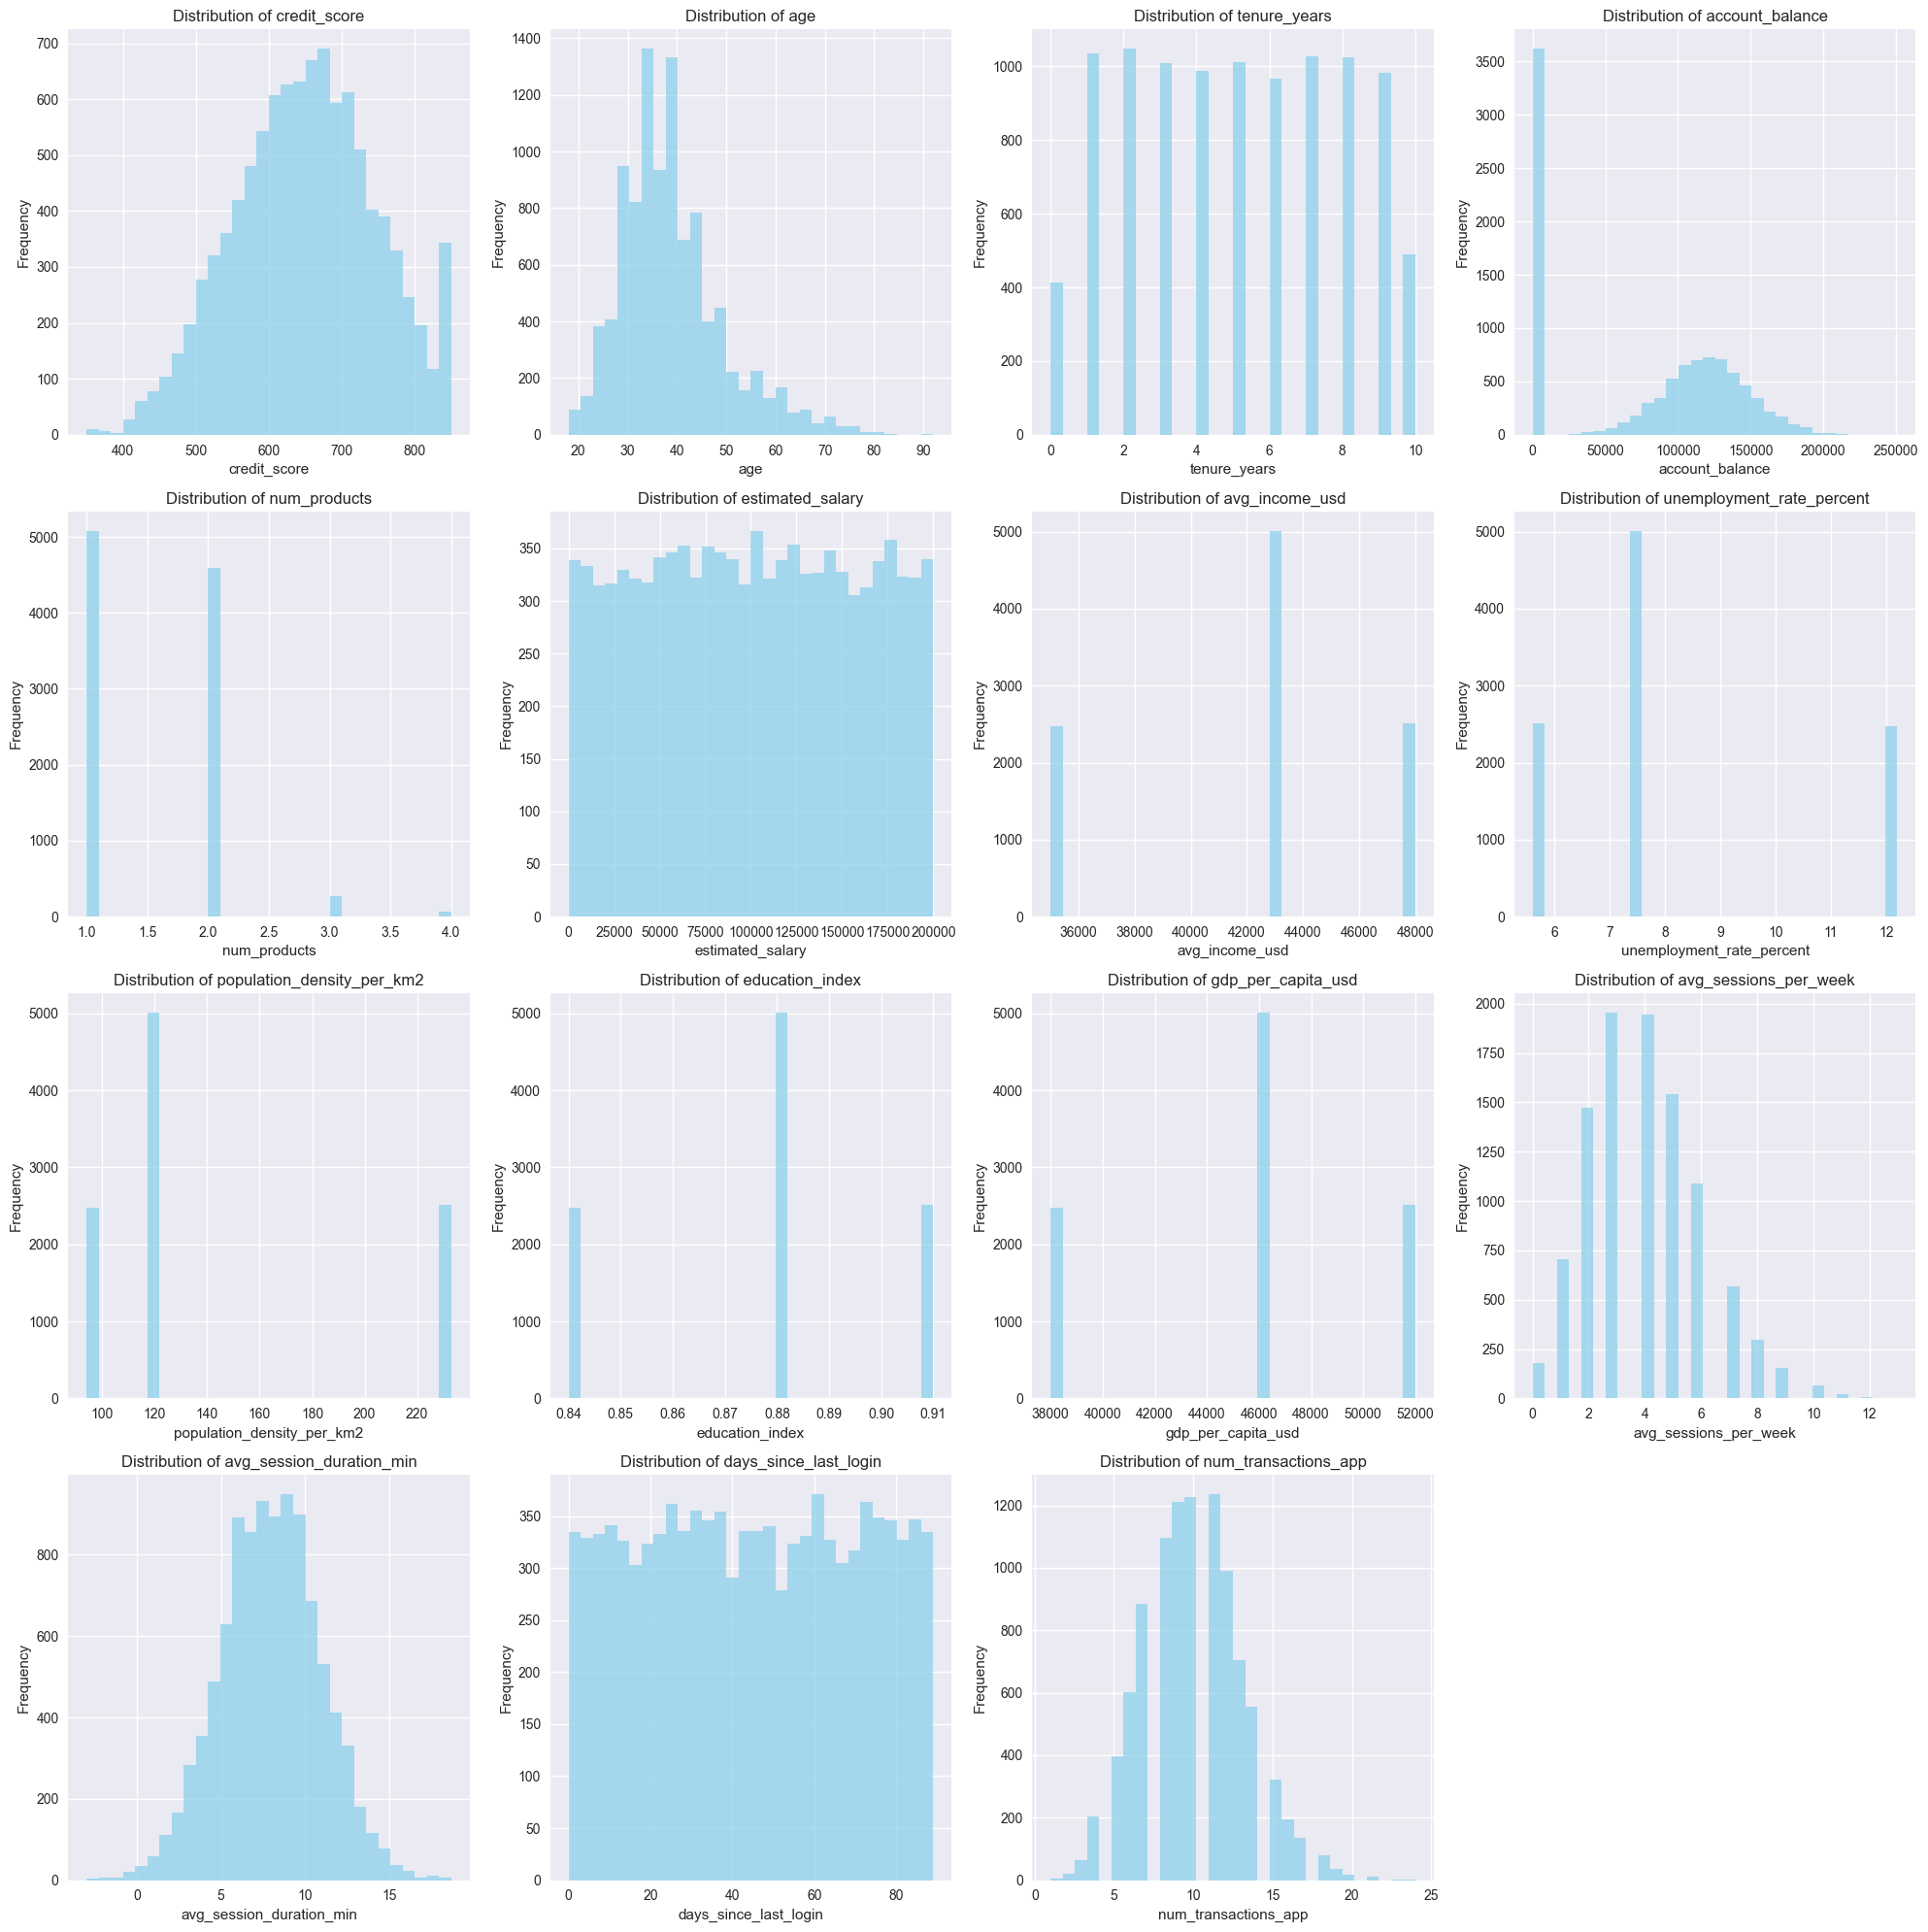

In [32]:
print("="*50)
print("ANALISIS GRAFICO VARIABLES NUMERICAS")
print("="*50)

numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = [col for col in numerical_cols if col not in ['row_number', 'customer_id']]

# Distribution plots for numerical variables
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i < len(axes):
        df[col].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()



### MULTIVARIADO

ANALISIS DE CORRELACIONES


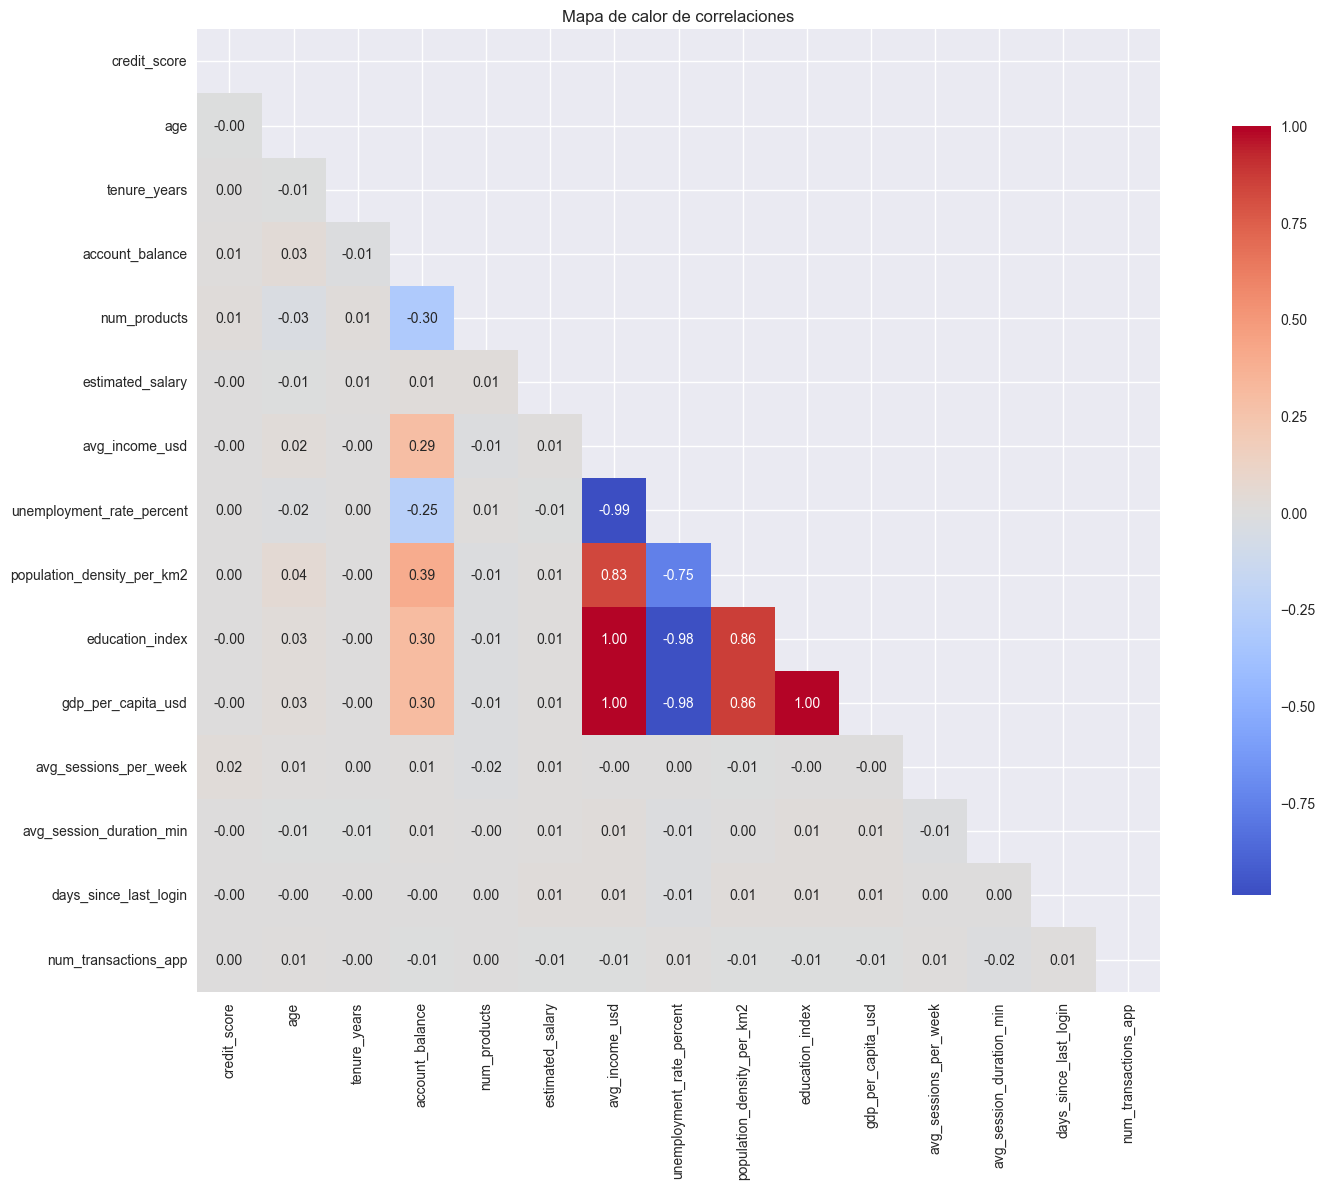

In [33]:
print("="*50)
print("ANALISIS DE CORRELACIONES")
print("="*50)

# Select numerical columns for correlation
numerical_cols_for_corr = [col for col in numerical_cols if col not in ['row_number', 'customer_id']]

# Correlation matrix
corr_matrix = df[numerical_cols_for_corr].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Mapa de calor de correlaciones')
plt.tight_layout()
plt.show()

# Correlation with target variable
if 'exited' in numerical_cols_for_corr:
    target_corr = corr_matrix['exited'].sort_values(ascending=False)
    print(f"\nCorrelaciones con exited:")
    print(target_corr)
    
    # Plot top correlations with target
    plt.figure(figsize=(10, 6))
    top_corr = target_corr.drop('exited').head(10)
    colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
    plt.barh(range(len(top_corr)), top_corr.values, color=colors)
    plt.yticks(range(len(top_corr)), top_corr.index)
    plt.xlabel('Coefficiente de correlacion')
    plt.title('Top de caracteristicas correlacionadas con exited')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

**Mapa de Calor de Correlaciones**

El siguiente mapa de calor muestra las correlaciones entre las variables numéricas del dataset.  
Los valores cercanos a **+1 o -1** indican relaciones fuertes (positivas o negativas), mientras que valores cercanos a **0** indican ausencia de correlación.

---

**Principales hallazgos**

1. **Alta correlación positiva entre variables socioeconómicas:**
   - `education_index`, `gdp_per_capita_usd` y `avg_income_usd` presentan **correlaciones cercanas a 1.00** entre sí.
   - Esto sugiere que estas tres variables representan **dimensiones similares del desarrollo económico** (nivel educativo, ingreso promedio y PIB per cápita).
   - En análisis predictivos, podrían considerarse **redundantes**, y bastaría mantener una sola (por ejemplo, `avg_income_usd`).

2. **Correlación negativa fuerte con desempleo:**
   - `unemployment_rate_percent` tiene una **correlación negativa muy alta (-0.98 a -0.99)** con las variables anteriores.
   - Esto es lógico: a mayor ingreso o educación, menor desempleo.
   - Muestra coherencia interna y **validez socioeconómica** del dataset.

3. **Relación entre `population_density_per_km2` y las variables socioeconómicas:**
   - Tiene correlación **positiva moderada (0.83)** con `education_index` y `gdp_per_capita_usd`, y **negativa (-0.75)** con `unemployment_rate_percent`.
   - Indica que las zonas más densamente pobladas tienden a tener **mayor desarrollo y menor desempleo**.

4. **`num_products` y `account_balance`:**
   - Existe una correlación **negativa débil (-0.30)**, lo que sugiere que los clientes con más productos bancarios tienden a mantener balances algo menores.
   - Puede reflejar una **diversificación del uso de productos**, donde los fondos se distribuyen entre cuentas o servicios.

5. **Otras correlaciones:**
   - Variables como `credit_score`, `age`, `tenure_years`, `estimated_salary`, `avg_sessions_per_week`, `avg_session_duration_min`, `days_since_last_login` y `num_transactions_app` muestran **correlaciones casi nulas** con el resto.
   - Esto sugiere que son **variables independientes**

---

**Conclusiones**

- El dataset presenta **grupos de variables altamente correlacionadas** (bloque socioeconómico), mientras que la mayoría de las demás son **independientes**, lo que favorece la diversidad informativa del modelo.  
- Se recomienda:
  - Aplicar **reducción de dimensionalidad** o **eliminar variables redundantes** (`education_index`, `gdp_per_capita_usd`, `avg_income_usd`) para evitar multicolinealidad.
  - Conservar las variables **independientes** (`age`, `credit_score`, `account_balance`, `is_active_member`, etc.).

En general, el mapa de calor muestra un **dataset coherente y equilibrado**, con relaciones lógicas entre variables y sin evidencia de correlaciones anómalas.


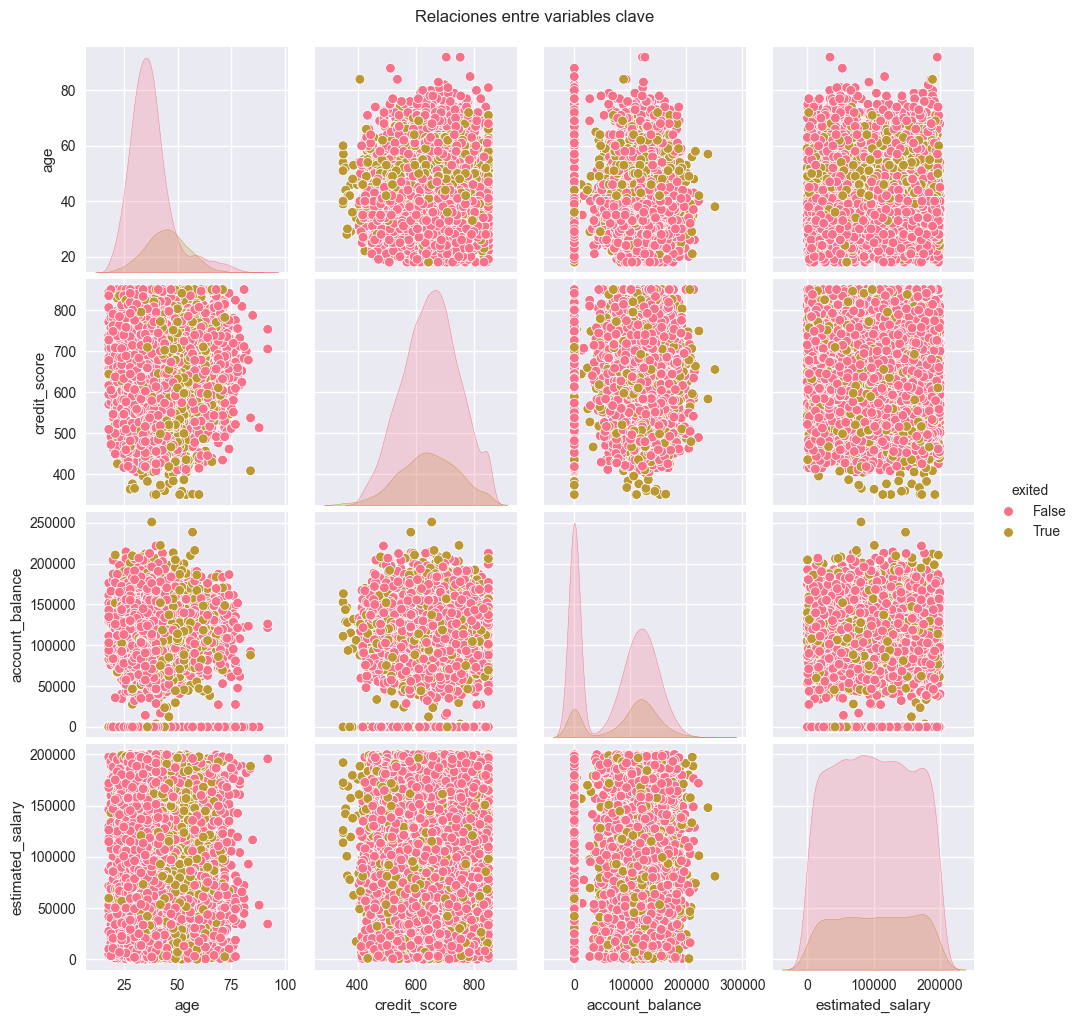

In [34]:
# Pairplot entre variables clave
sns.pairplot(df[['age', 'credit_score', 'account_balance', 'estimated_salary', 'exited']],
             hue='exited', diag_kind='kde')
plt.suptitle('Relaciones entre variables clave', y=1.02)
plt.show()


#### **Distribución individual (diagonales)**

- **Edad (`age`)**:  
  La mayoría de los clientes se concentran entre los **30 y 45 años**, con un grupo menor de mayores de 60.  
  Los puntos en color naranja (clientes que abandonaron) se concentran principalmente en las edades **mayores**, lo que sugiere que la edad influye en la probabilidad de abandono.

- **Puntaje crediticio (`credit_score`)**:  
  Presenta una distribución **simétrica**, centrada alrededor de **650**.  
  No se observan diferencias claras entre los clientes que se van y los que permanecen, lo que indica que esta variable no es determinante en el abandono.

- **Balance de cuenta (`account_balance`)**:  
  Se observa una **distribución bimodal**, con muchos clientes sin saldo (0) y otro grupo con balances que llegan hasta 250,000.  
  Algunos clientes con **saldo medio o alto** presentan mayor proporción de abandono, aunque la tendencia no es muy fuerte.

- **Salario estimado (`estimated_salary`)**:  
  Tiene una distribución **uniforme** a lo largo del rango (0–200,000), sin diferencias evidentes entre los clientes que se quedan o se van.  
  Esto sugiere que el salario no está directamente relacionado con el abandono.

---

**Relaciones bivariadas (fuera de la diagonal)**

- **Edad vs Balance:**  
  Los clientes de mayor edad tienden a tener balances más altos, y entre ellos se observan más casos de abandono.  

- **Edad vs Credit Score:**  
  No existe una correlación clara, aunque los clientes mayores con puntajes medios (~650) parecen abandonar con mayor frecuencia.  

- **Balance vs Credit Score:**  
  No hay una relación lineal evidente; el puntaje crediticio no predice el balance.  

- **Salario vs Balance:**  
  La dispersión es amplia y uniforme, indicando que **ingresos y balance son independientes** entre sí.

---

**Conclusiones**

- La **edad** es la variable más asociada con el abandono: los clientes **de mayor edad tienen más probabilidad de salir del banco**.  
- El **balance** podría tener una influencia secundaria en el abandono.  
- **`credit_score`** y **`estimated_salary`** no muestran relación significativa con la variable objetivo.  
- En general, **no hay correlaciones lineales fuertes entre las variables numéricas**




## ANALISIS DE OUTLIERS
El conjunto de boxplots permite identificar la **distribución, dispersión y presencia de valores atípicos (outliers)** en cada variable numérica del dataset.  
A continuación se presentan las observaciones más relevantes:

ANALISIS DE OUTLIERS - BOXPLOTS


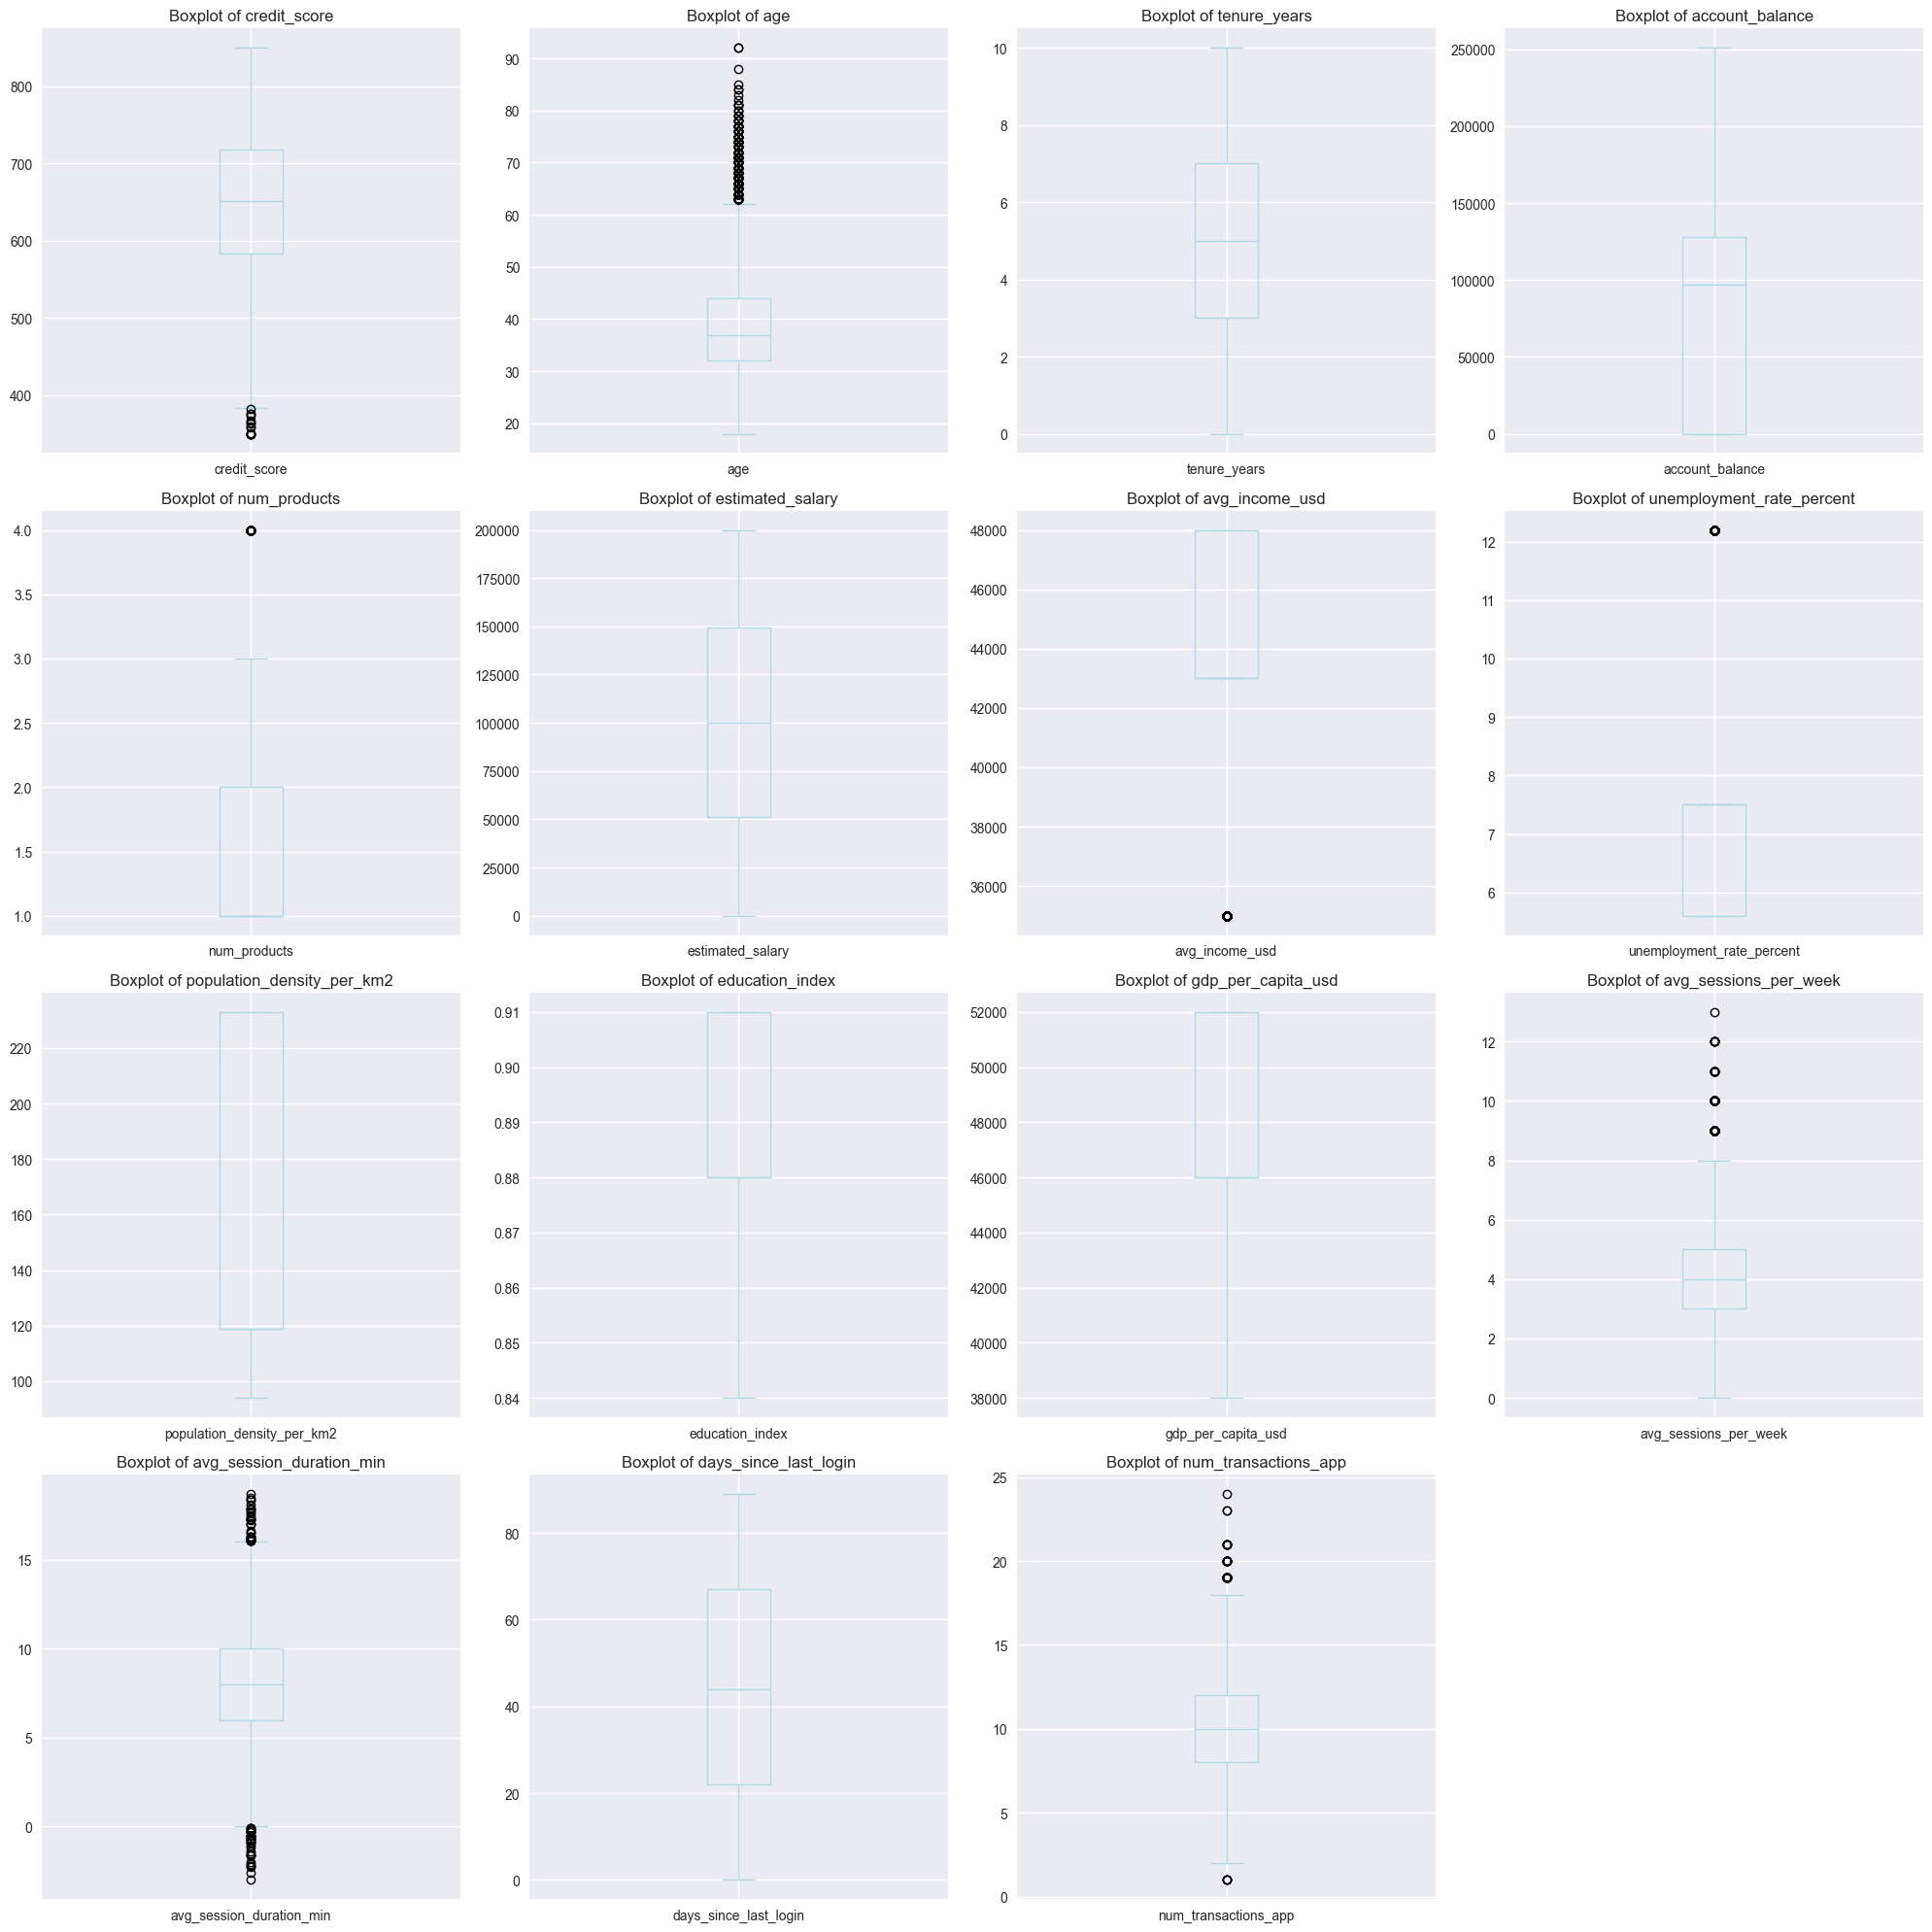

In [35]:
print("="*50)
print("ANALISIS DE OUTLIERS - BOXPLOTS")
print("="*50)

# Boxplots for outlier detection
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i < len(axes):
        df.boxplot(column=col, ax=axes[i], color='lightblue')
        axes[i].set_title(f'Boxplot of {col}')

for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

#### **Análisis de Boxplots – Distribución de Variables Numéricas**

**1. credit_score**
- Distribución centrada entre **600 y 700**, con algunos valores atípicos menores a 400.
- La dispersión es moderada, indicando cierta homogeneidad en el puntaje crediticio de los clientes.

**2. age**
- Se observa una alta concentración entre **30 y 45 años**, pero con varios **outliers por encima de 70**, que representan a clientes de mayor edad.
- Esto podría tener implicaciones al analizar la retención, ya que los clientes mayores podrían tener comportamientos distintos.

**3. tenure_years**
- Distribución uniforme entre 0 y 10 años de antigüedad en el banco.
- No se observan valores extremos, lo cual indica que los datos de antigüedad son consistentes.

**4. account_balance**
- Presenta una gran dispersión y algunos valores muy altos.
- Existen **clientes con balance 0**, posiblemente cuentas inactivas o de ahorro reciente.
- Los valores atípicos altos pueden corresponder a clientes con grandes depósitos o cuentas premium.

**5. num_products**
- Distribución concentrada en **1 y 2 productos**, con pocos casos que poseen 3 o más.
- Los valores atípicos indican clientes con una mayor vinculación al banco.

**6. estimated_salary**
- Distribución amplia pero sin valores atípicos relevantes.
- La dispersión refleja una **amplia variedad de salarios**, lo que sugiere diversidad en el perfil económico de los clientes.

**7. avg_income_usd, unemployment_rate_percent, population_density_per_km2, education_index, gdp_per_capita_usd**
- Variables **macro o socioeconómicas** con poca variabilidad interna.
- Se observan algunos outliers leves, pero la mayoría de los datos están concentrados en rangos estables.

**8. avg_sessions_per_week**
- Distribución concentrada en valores bajos (1 a 5 sesiones).
- Algunos **outliers altos (>10)** indican usuarios muy activos.

**9. avg_session_duration_min**
- Promedio de duración de sesión cercano a **10 minutos**, con **outliers por debajo de 5 min y por encima de 15**.
- Podría reflejar diferentes niveles de compromiso con la aplicación.

**10. days_since_last_login**
- Rango amplio (0 a ~80 días) y sin outliers notables.
- Indica que algunos usuarios se conectan con poca frecuencia.

**11. num_transactions_app**
- Distribución concentrada en valores bajos, con **outliers altos** que indican usuarios con mucha actividad transaccional.
- Sugiere la existencia de segmentos diferenciados entre usuarios pasivos y altamente activos.

---

**Conclusiones**

- Existen **variables con valores atípicos claros** (por ejemplo: `age`, `credit_score`, `account_balance`, `avg_sessions_per_week`, `num_transactions_app`), que deben considerarse en la limpieza o normalización de datos.  
- Algunas variables presentan **alta dispersión** (como `account_balance` y `estimated_salary`), lo cual podría afectar el rendimiento de modelos sensibles a la escala.
- Las variables socioeconómicas (`education_index`, `gdp_per_capita_usd`, etc.) son estables, lo que sugiere que no generan ruido significativo.
- En general, el dataset parece **limpio y consistente**




## ANALISIS VARIABLES CATEGORICAS

6. CATEGORICAL VARIABLES ANALYSIS

Resumen de columnas categóricas:

surname:
surname
Smith     32
Scott     29
Martin    29
Walker    28
Brown     26
Name: count, dtype: int64

gender:
gender
Male      5457
Female    4543
Name: count, dtype: int64

has_credit_card:
has_credit_card
True     7055
False    2945
Name: count, dtype: int64

is_active_member:
is_active_member
True     5151
False    4849
Name: count, dtype: int64

Country:
Country
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

device_type:
device_type
ios        3379
web        3336
android    3285
Name: count, dtype: int64

most_active_time_of_day:
most_active_time_of_day
Night        2522
Morning      2515
Evening      2507
Afternoon    2456
Name: count, dtype: int64

push_notifications_enabled:
push_notifications_enabled
True     6939
False    3061
Name: count, dtype: int64

biometric_login_used:
biometric_login_used
True     6042
False    3958
Name: count, dtype: int64

dark_mode_enabled:
dark_

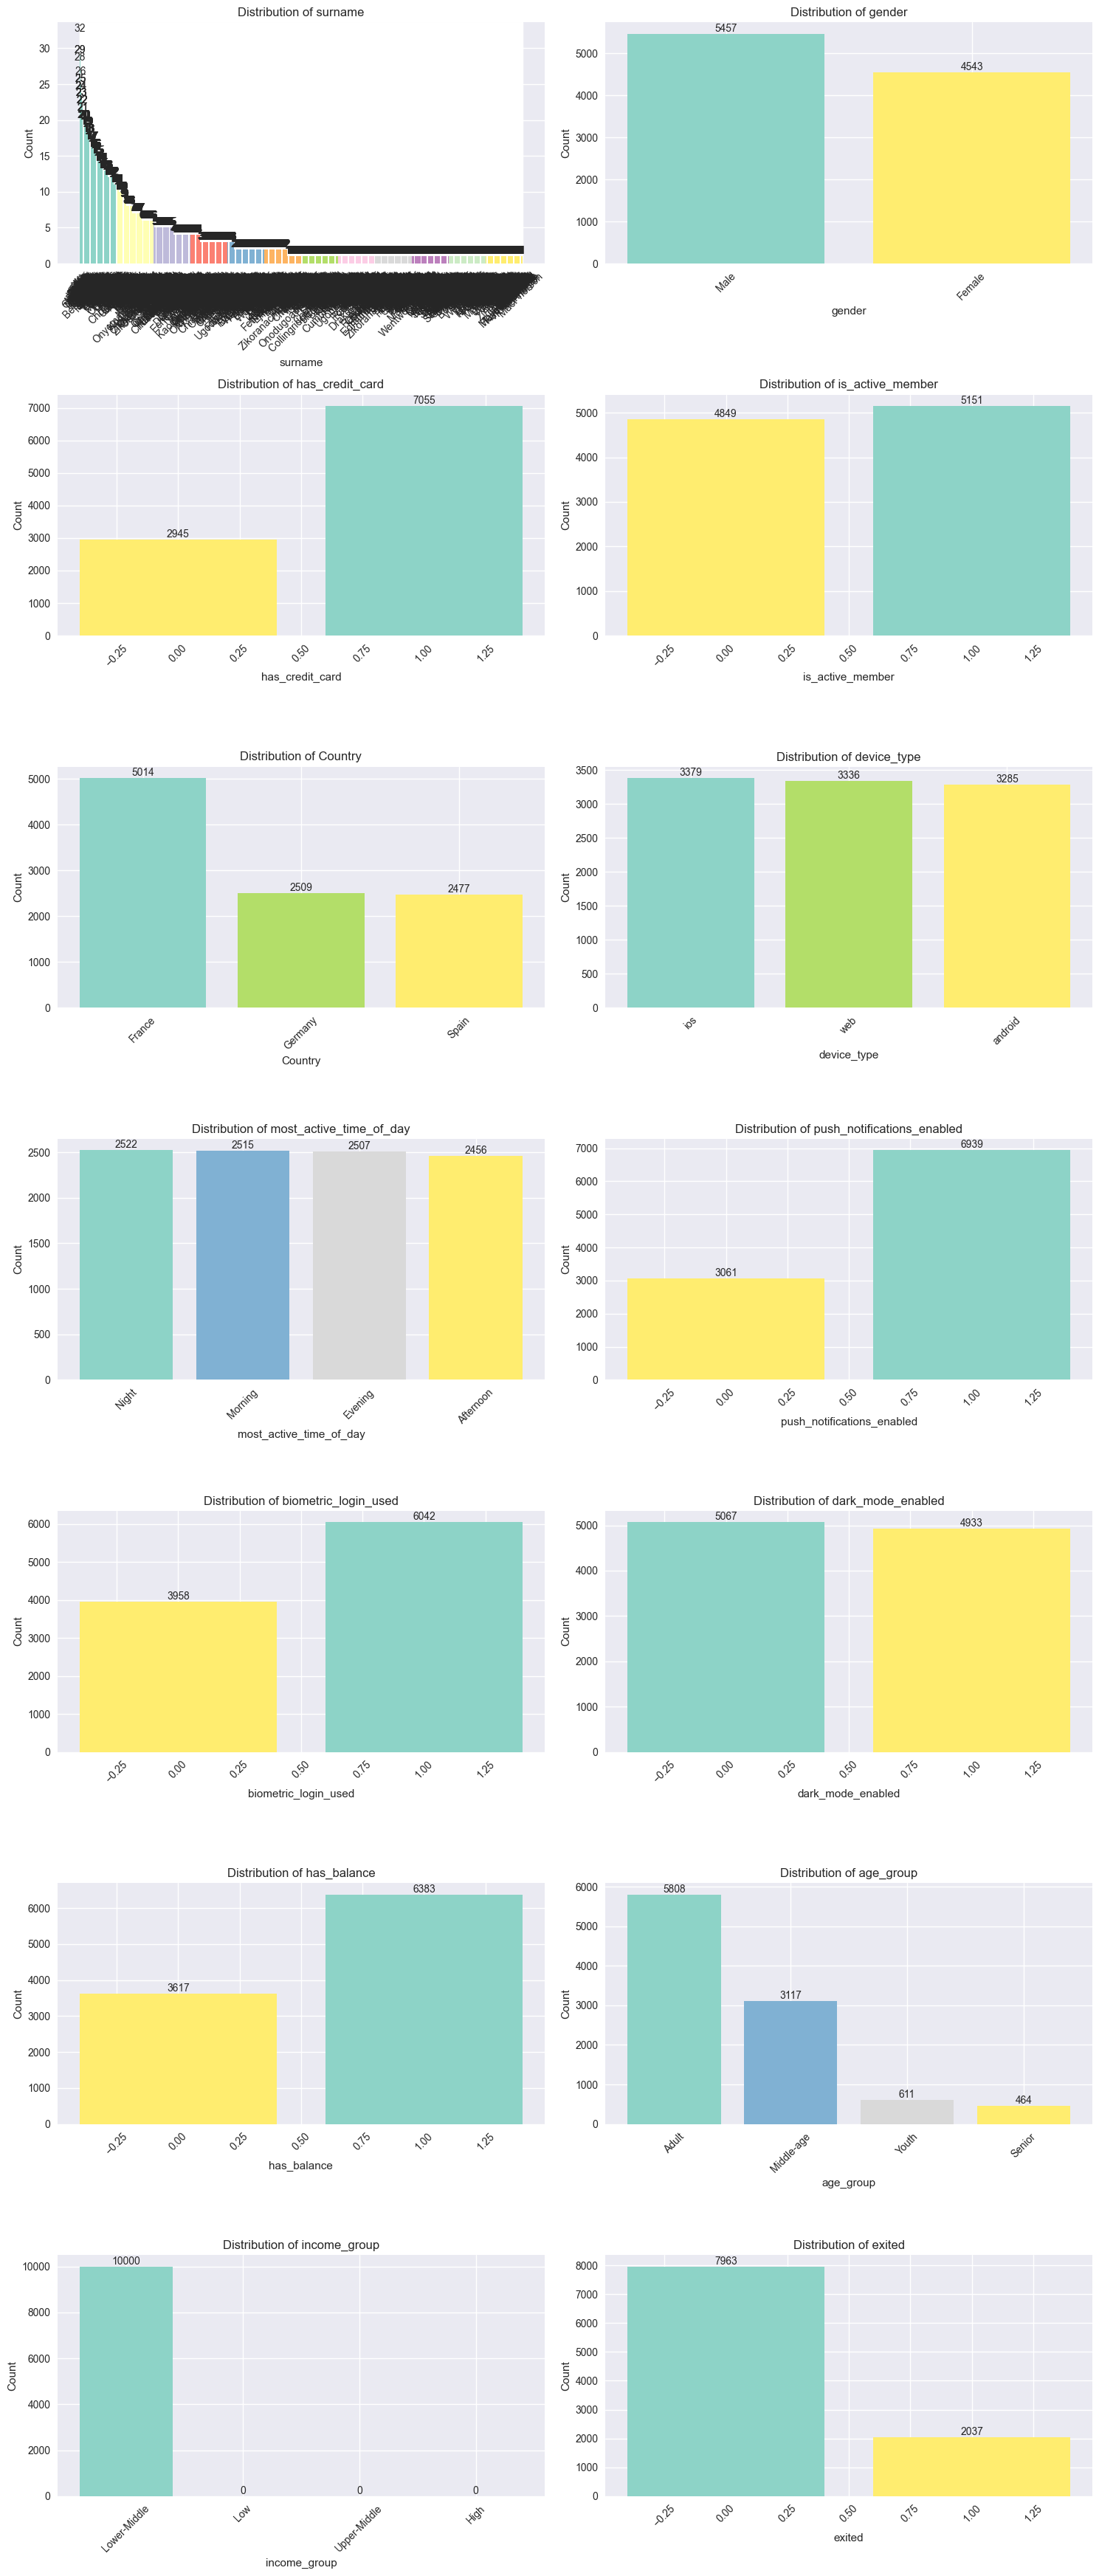

In [36]:
print("="*50)
print("6. CATEGORICAL VARIABLES ANALYSIS")
print("="*50)

##categorical_cols = df.select_dtypes(include=['object']).columns
##categorical_cols = [col for col in categorical_cols if col not in ['customer_id', 'surname']]
# Categorical columns summary - include object, category, and bool
categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
if len(categorical_cols) > 0:
    print("\nResumen de columnas categóricas:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts().head())

if len(categorical_cols) > 0:
    n_cols = 2
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        if i < len(axes):
            value_counts = df[col].value_counts()
            bars = axes[i].bar(value_counts.index, value_counts.values, color=plt.cm.Set3(np.linspace(0, 1, len(value_counts))))
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height,
                            f'{int(height)}', ha='center', va='bottom')
    
    # Hide empty subplots
    for i in range(len(categorical_cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found (excluding customer_id and surname)")

### Análisis de Variables Categóricas

**1. Distribución por país**
- **Francia (50.1%)**, **Alemania (25.1%)** y **España (24.8%)** presentan una distribución relativamente equilibrada, aunque Francia domina ligeramente la muestra.
- Esta diversidad geográfica puede influir en los comportamientos financieros y en la tasa de abandono (`exited`).

**2. Género**
- La proporción entre géneros es **equilibrada**: 54.6% hombres y 45.4% mujeres.
- No hay sesgo de género significativo en la composición del dataset.

**3. has_credit_card**
- El **70.5%** de los clientes posee tarjeta de crédito, mientras que el **29.5%** no.
- Esto indica una alta penetración de productos financieros básicos dentro de la base de clientes.

**4. is_active_member**
- Los **clientes activos** (51.5%) superan ligeramente a los inactivos (48.5%).
- La proporción cercana al 50/50 sugiere un equilibrio entre usuarios comprometidos y usuarios con baja interacción.

**5. device_type**
- La distribución por dispositivo es **muy homogénea**:
  - iOS: 33.8%
  - Web: 33.4%
  - Android: 32.8%
- Esto muestra que los clientes acceden al banco desde múltiples plataformas de manera similar, lo que sugiere una buena adopción multicanal.

**6. most_active_time_of_day**
- Las franjas horarias presentan una distribución prácticamente uniforme:
  - Noche: 25.2%
  - Mañana: 25.1%
  - Tarde: 24.6%
  - Noche: 25.0%
- No hay una preferencia marcada, aunque **ligeramente mayor en horas nocturnas**, lo que puede asociarse a mayor uso digital fuera del horario laboral.

**7. push_notifications_enabled**
- El **69.4%** de los usuarios tiene activadas las notificaciones push.
- Indica una **alta apertura a la comunicación digital**, ideal para estrategias de marketing automatizado o retención.

**8. biometric_login_used**
- Un **60.4%** de los usuarios utiliza login biométrico.
- Refleja una buena adopción de medidas de seguridad avanzadas y tecnologías móviles modernas.

**9. dark_mode_enabled**
- Distribución casi equilibrada: 50.7% lo tiene desactivado, 49.3% activado.
- Indica flexibilidad en preferencias visuales, sin sesgo hacia un modo específico.

**10. has_balance**
- El **63.8%** de los clientes mantiene un saldo positivo, mientras que el **36.2%** no.
- Sugiere que una parte considerable de la base podría tener cuentas inactivas o sin uso reciente.

**11. age_group**
- Distribución por grupo etario:
  - **Adultos (58%)** predominan.
  - **Middle-age (31%)**, **jóvenes (6%)** y **seniors (5%)** son minoría.
- Esto indica que la mayoría de los clientes se encuentran en **etapas laborales activas**, con poder adquisitivo medio.

**12. income_group**
- Todos los clientes pertenecen al grupo **“Lower-Middle” (100%)**.
- Esto significa que no hay variabilidad en esta categoría; puede ser un campo simulado o codificado uniformemente.

**13. exited (variable objetivo)**
- **20.4%** de los clientes han abandonado el banco (`exited = True`).
- Esto representa una tasa de abandono moderada, ideal para análisis de *churn prediction*.

---

**Conclusiones**

- El dataset presenta **equilibrio demográfico y tecnológico**, con buena representación de género, países y tipos de dispositivo.  
- La mayoría de los usuarios **mantiene actividad digital**, con alta adopción de **notificaciones push** y **biometría**.  
- Casi todos los clientes pertenecen al segmento **Lower-Middle**, lo que sugiere una base de clientes homogénea en nivel socioeconómico.  
- La variable `exited` (20%) ofrece una proporción adecuada para el entrenamiento de modelos predictivos de abandono.  

En conjunto, las variables categóricas están **bien distribuidas y balanceadas**


# Conclusión General del Análisis Exploratorio de Datos (EDA)

El análisis exploratorio del conjunto de datos permitió identificar patrones clave sobre el comportamiento de los clientes y los posibles factores asociados al abandono del servicio (churn).

### 1. Distribución de clientes

- La mayoría de los clientes proviene de Francia (≈50%), seguidos por Alemania y España.
- La variable género muestra un equilibrio entre hombres (≈55%) y mujeres (≈45%).
- En cuanto a edad, predominan los grupos adultos y de mediana edad.
- Todos los registros pertenecen al grupo de ingresos Lower-Middle, indicando una muestra homogénea en nivel socioeconómico.

### 2. Comportamiento digital y uso del servicio

- El uso de dispositivos está bien distribuido entre web, iOS y Android, con ligera ventaja de usuarios iOS.
- Un 70% posee tarjeta de crédito y más del 60% utiliza inicio de sesión biométrico.
- La mayoría tiene notificaciones push activadas y el uso del modo oscuro está balanceado.
- Las franjas horarias de actividad están equilibradas entre mañana, tarde, noche y madrugada, lo que sugiere interacción constante durante el día.

### 3. Variables financieras y demográficas

- Las variables credit_score, account_balance, estimated_salary y num_products no presentan diferencias notorias entre clientes que abandonaron y los que permanecen.
- La variable edad (age) sí muestra diferencia: los clientes de mayor edad tienden a abandonar con más frecuencia.
- No se observan correlaciones fuertes entre las variables numéricas; el mapa de calor de correlaciones muestra relaciones débiles, excepto entre indicadores macroeconómicos:
  - avg_income_usd, education_index, gdp_per_capita_usd y unemployment_rate_percent presentan correlaciones altas entre sí, lo que indica coherencia estructural del dataset.

### 4. Tasa de abandono (churn)

- Aproximadamente el 20% de los clientes ha abandonado el servicio (exited=True), una tasa relevante que justifica la implementación de modelos predictivos y estrategias de retención.



### Conclusión Integrada

En conjunto, los resultados sugieren que:

- El abandono de clientes no depende significativamente de factores financieros, sino de variables demográficas (edad) y de comportamientos digitales.  
- Se recomienda enfocar las estrategias de retención en:
  - Clientes de mayor edad.
  - Fomentar la interacción digital activa (uso de app, notificaciones, inicio biométrico, etc.).
- La baja correlación entre variables numéricas indica que el conjunto de datos es apto para modelado predictivo multivariable, como árboles de decisión, random forest o gradient boosting, sin riesgo de multicolinealidad significativa.


Conclusión Final:  
El dataset es coherente, limpio y balanceado, con una estructura sólida para el desarrollo de modelos de predicción de churn.  
Las relaciones observadas ofrecen bases sólidas para estrategias de retención y segmentación de clientes desde un enfoque analítico y basado en datos.